In [1]:
from pytezos import ContractInterface, pytezos, MichelsonRuntimeError
import time
from tqdm import tqdm

In [2]:
RUN_TIME = int(time.time())
ONE_HOUR = 60*60

contract_fn = '../pytezos-tests/baking_bet.tz'

a='tz1iQE8ijR5xVPffBUPFubwB9XQJuyD9qsoJ'
b='tz1MdaJfWzP5pPx3gwPxfdLZTHW6js9havos'
c='tz1RS9GoEXakf9iyBmSaheLMcakFRtzBXpWE'
d='tz1TdKuFwYgbPHHb7y1VvLH4xiwtAzcjwDjM'

contract = ContractInterface.from_file(contract_fn)

storage = {
    'events': {},
    'betsForWinningLedger': {},
    'betsAgainstWinningLedger': {},
    'providedLiquidityLedger': {},
    'liquidityForBonusLedger': {},
    'liquidityAgainstBonusLedger': {},
    'depositedBets': {},
    'lastEventId': 0,
    'closeCallEventId': None,
    'measurementStartCallEventId': None
}

event_params = {
    'currencyPair': 'XTZ-USD',
    'targetDynamics': 1_000_000,
    'betsCloseTime': RUN_TIME + 24*ONE_HOUR,
    'measurePeriod': 12*ONE_HOUR,
    'oracleAddress': 'KT1SUP27JhX24Kvr11oUdWswk7FnCW78ZyUn',

    'liquidityPercent': 40_000,  # 4% of 1_000_000
    'measureStartFee': 200_000,  # who provides it and when?
    'expirationFee': 100_000
}

In [3]:
current_time = RUN_TIME

# Creating event
result = contract.newEvent(event_params).interpret(
    storage=storage, sender=a, now=current_time)
storage = result.storage

# Providing basic liquidity
transaction = contract.provideLiquidity(
    eventId=0, expectedRatioAgainst=3, expectedRatioFor=1, maxSlippage=100_000)
transaction = transaction.with_amount(20_000_000)
result = transaction.interpret(storage=storage, sender=a, now=current_time)
storage = result.storage

In [4]:
def get_params(storage, event_id, participant):
    key = (participant, event_id)

    sum_against = storage['events'][event_id]['betsAgainstLiquidityPoolSum']
    sum_for = storage['events'][event_id]['betsForLiquidityPoolSum']
    total_sum = sum_against + sum_for

    ratio_against = sum_against / total_sum
    ratio_for = sum_for / total_sum

    winning_for = result.storage['betsForWinningLedger'].get(key, 0)
    winning_against = result.storage['betsAgainstWinningLedger'].get(key, 0)
    deposited_bets = result.storage['depositedBets'].get(key, 0)

    expected_value = winning_for*ratio_for + winning_against*ratio_against - deposited_bets

    return dict(
        sum_against = sum_against,
        sum_for = sum_for,
        ratio_against = ratio_against,
        ratio_for = ratio_for,
        winning_for = winning_for,
        winning_against = winning_against,
        deposited_bets = deposited_bets,
        expected_value = expected_value
    )

In [5]:
def bets_generator():
    while True:
        yield ('against', 9_000_000)
        yield ('for', 3_000_000)

result_params = {}
bet = bets_generator()

for counter in tqdm(range(75)):
    selected_bet, bet_size = next(bet)

    result = contract.bet(bet=selected_bet, eventId=0, minimalWinAmount=0).with_amount(bet_size).interpret(
        storage=storage, sender=b, now=current_time)
    storage = result.storage

    params = get_params(result.storage, event_id=0, participant=b)
    params['bet_size'] = bet_size

    result_params[f'{counter}_bets_{selected_bet}'] = params


100%|██████████| 75/75 [00:15<00:00,  4.93it/s]


In [6]:
import pandas as pd

df = pd.DataFrame(result_params).T

In [7]:
winning_for_ratio = df['winning_for'] / df['deposited_bets']

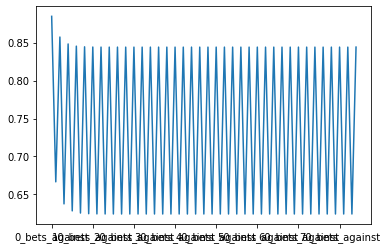

In [8]:
ax = df.ratio_against.plot()
# winning_for_ratio.plot(ax=ax, color='#333333')

<AxesSubplot:>

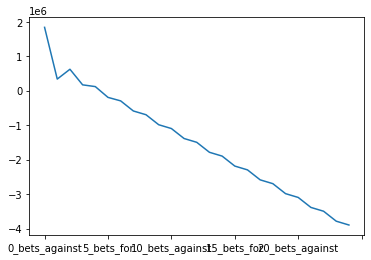

In [9]:
df.expected_value.plot()